# Computes the FF either analytically or filtering computationally and calculating SNR / SNR_res
### Note that for high chi, increasing the srate may be necessary

In [26]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [27]:
import numpy as np
import matplotlib.pyplot as pl
import qnm_filter
import qnm
import astropy.constants as c
T_MSUN = c.M_sun.value * c.G.value / c.c.value**3

In [29]:
mode_inj = '220'
mode_filt = '330'
injected = [50, 0.7]
phi = 0 #np.random.uniform(0, 2*np.pi)
mass = qnm_filter.Filter.mass_unit(injected[0])

In [30]:
w_inj, _, _ = qnm.modes_cache(s=-2,l=int(mode_inj[0]),m=int(mode_inj[1]),n=int(mode_inj[2]))(a=injected[1])
w_filt, _, _ = qnm.modes_cache(s=-2,l=int(mode_filt[0]),m=int(mode_filt[1]),n=int(mode_filt[2]))(a=injected[1])
filt = (w_inj-w_filt)/(w_inj-np.conj(w_filt))*(w_inj+np.conj(w_filt))/(w_inj+w_filt)
B = np.abs(filt)
psi = -np.angle(filt) #The (-) sign is negative and I think because of different conventions
f_inj = np.real(w_inj)/(2*np.pi)
tau_inj = -1/np.imag(w_inj)
wt = 2*np.pi*f_inj*tau_inj

In [31]:
temp0 = B**2*(1+wt**2+np.cos(2*(phi+psi))-wt*np.sin(2*(phi+psi)))
temp1 = 1+wt**2+np.cos(2*phi) - wt*np.sin(2*phi)
analytical_FF = np.sqrt(1-temp0/temp1)
print(analytical_FF)

0.5548007037127279


In [43]:
0.5*(1-analytical_FF**2)

0.2173154382896071

## How much does B vary?

In [22]:
chi_arr = np.linspace(0, 1, 100, endpoint=False)
B_arr = []
psi_arr = []

for chi in chi_arr:
    w_inj, _, _ = qnm.modes_cache(s=-2,l=2,m=2,n=0)(a=chi)
    w_filt, _, _ = qnm.modes_cache(s=-2,l=4,m=4,n=0)(a=chi)
    filt = (w_inj-w_filt)/(w_inj-np.conj(w_filt))*(w_inj+np.conj(w_filt))/(w_inj+w_filt)
    B = np.abs(filt)
    psi = -np.angle(filt) #The (-) sign is negative and I think because of different conventions
    B_arr.append(B)
    psi_arr.append(psi)

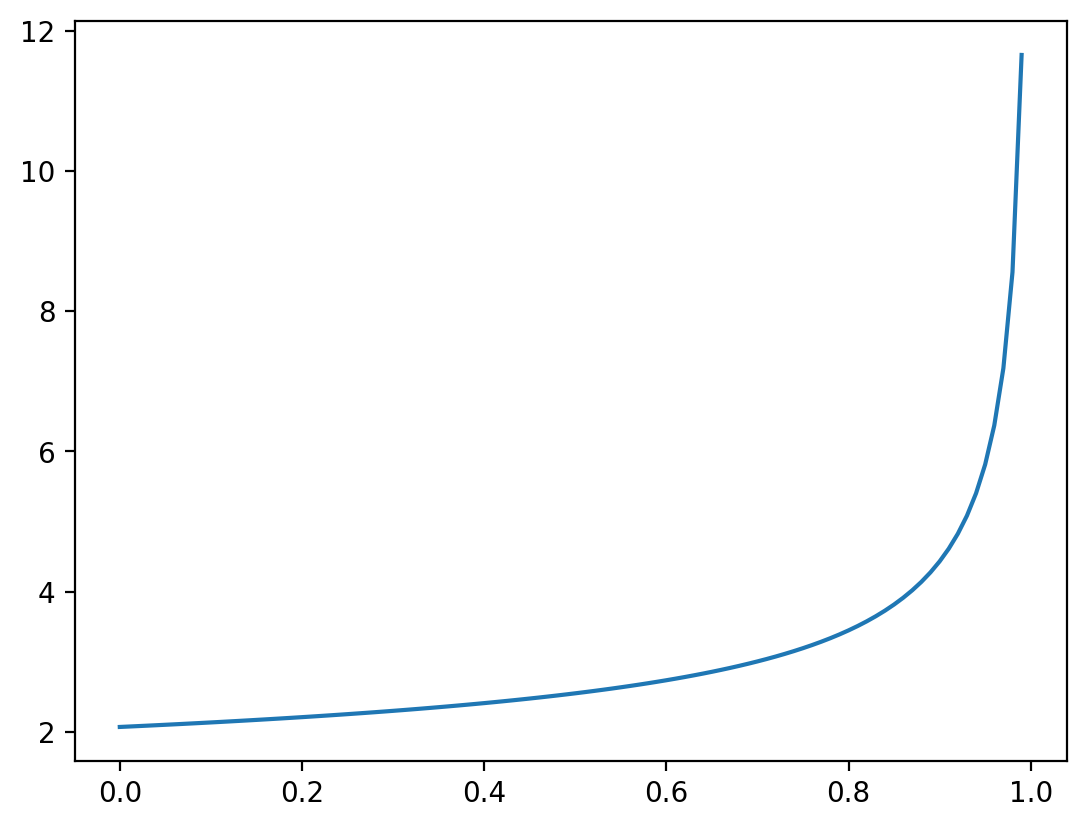

In [23]:
pl.plot(chi_arr, 1/np.sin(np.multiply(2, psi_arr)))

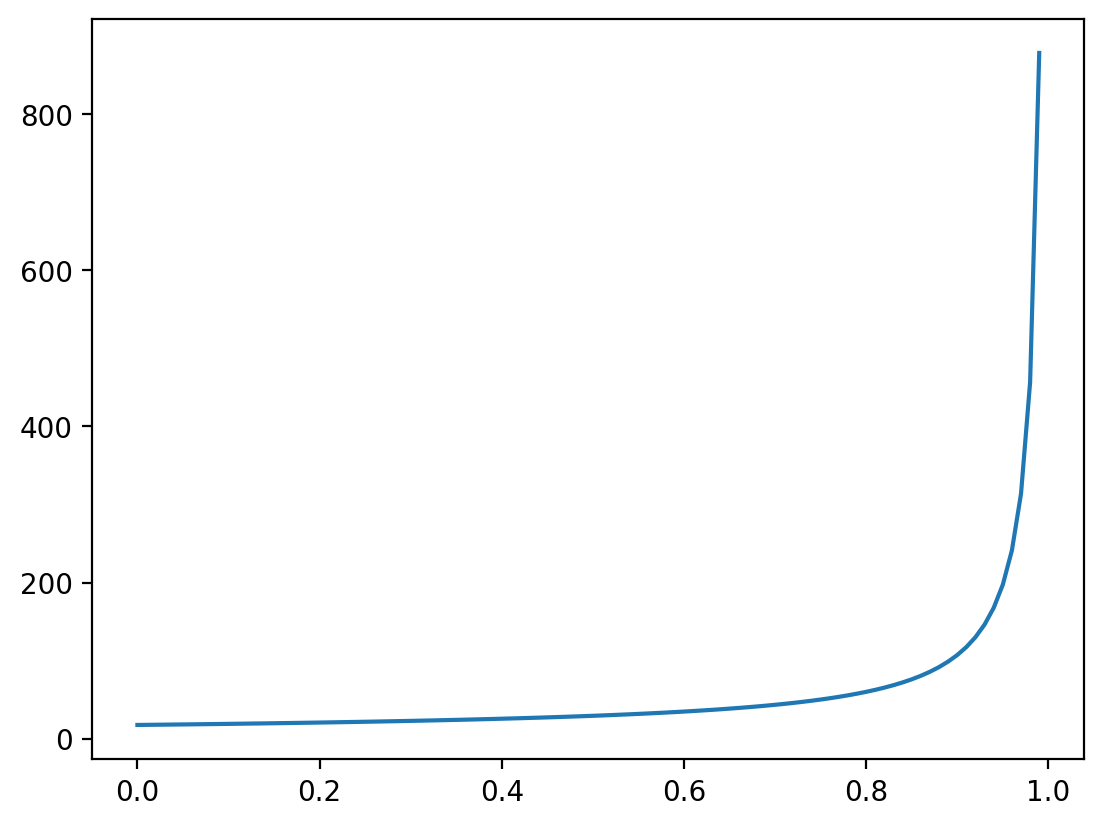

In [25]:
chi_arr = np.linspace(0, 1, 100, endpoint=False)
temp_arr = []

for chi in chi_arr:
    w_inj, _, _ = qnm.modes_cache(s=-2,l=2,m=2,n=0)(a=chi)
    omega = np.real(w_inj)
    tau = -1/np.imag(w_inj)
    temp_arr.append(omega**2*tau**2)
    
pl.plot(chi_arr, temp_arr)

## Waveform injection

In [6]:
def injected_waveform(t, tau, f, phi):
    temp0 = np.exp(-t/(tau*mass))*np.heaviside(t_range, 1)
    temp1 = np.cos(2*np.pi*f*t/mass+phi)
    return temp0*temp1

In [7]:
srate = 4096*8
t_range=np.arange(-2,2,1/srate)
signal=injected_waveform(t_range, tau_inj, f_inj, phi)
waveform = qnm_filter.RealData(signal, index=t_range)

In [8]:
mass = qnm_filter.Filter.mass_unit(injected[0])

input = dict(t_init = 0*mass, #Calculated from SNR+t_init notebook
             # length of the analysis window (in second)
             segment_length = 0.2,
             # sampling rate after conditioning (in Hz)
             srate = srate)

fit = qnm_filter.Network(**input)
fit.original_data['H1'] = waveform
fit.detector_alignment()
fit.condition_data('original_data', trim=0, remove_mean=False, **input)
fit.compute_acfs('original_data')

In [9]:
temp_acf = np.full(input['srate'], 0, dtype = np.double)
temp_acf[0] = 0.1**2
fit.acfs['H1'] = qnm_filter.RealData(temp_acf, index = fit.acfs['H1'].index)
fit.cholesky_decomposition()
fit.first_index()

In [10]:
template = fit.truncate_data(fit.original_data)['H1']
SNR = fit.compute_SNR(None, template, 'H1', optimal=True)
fit.add_filter(mass=injected[0], chi=injected[1], model_list=[(int(mode_filt[0]),int(mode_filt[1]),int(mode_filt[2]),'p')])
template_res = fit.truncate_data(fit.filtered_data)['H1']
SNR_res = fit.compute_SNR(None, template_res, 'H1', optimal=True)
empirical_FF = np.sqrt(1-SNR_res**2/SNR**2)
empirical_FF

0.8290144154398145

In [11]:
print("Absolute error is %5g" % np.abs(empirical_FF - analytical_FF))
print("Relative error is %5g" % (np.abs(empirical_FF - analytical_FF)/analytical_FF))

Absolute error is 0.00189671
Relative error is 0.00229316


In [12]:
def filtered_waveform(t, B, tau, f, phi, psi):
    temp0 = np.exp(-t/(tau*mass))*np.heaviside(t_range, 1)
    temp1 = np.cos(2*np.pi*f*t/mass+phi+psi)
    return B*temp0*temp1

analytic_filtered = filtered_waveform(t_range, B, tau_inj, f_inj, phi, psi)

(0.0, 0.02)

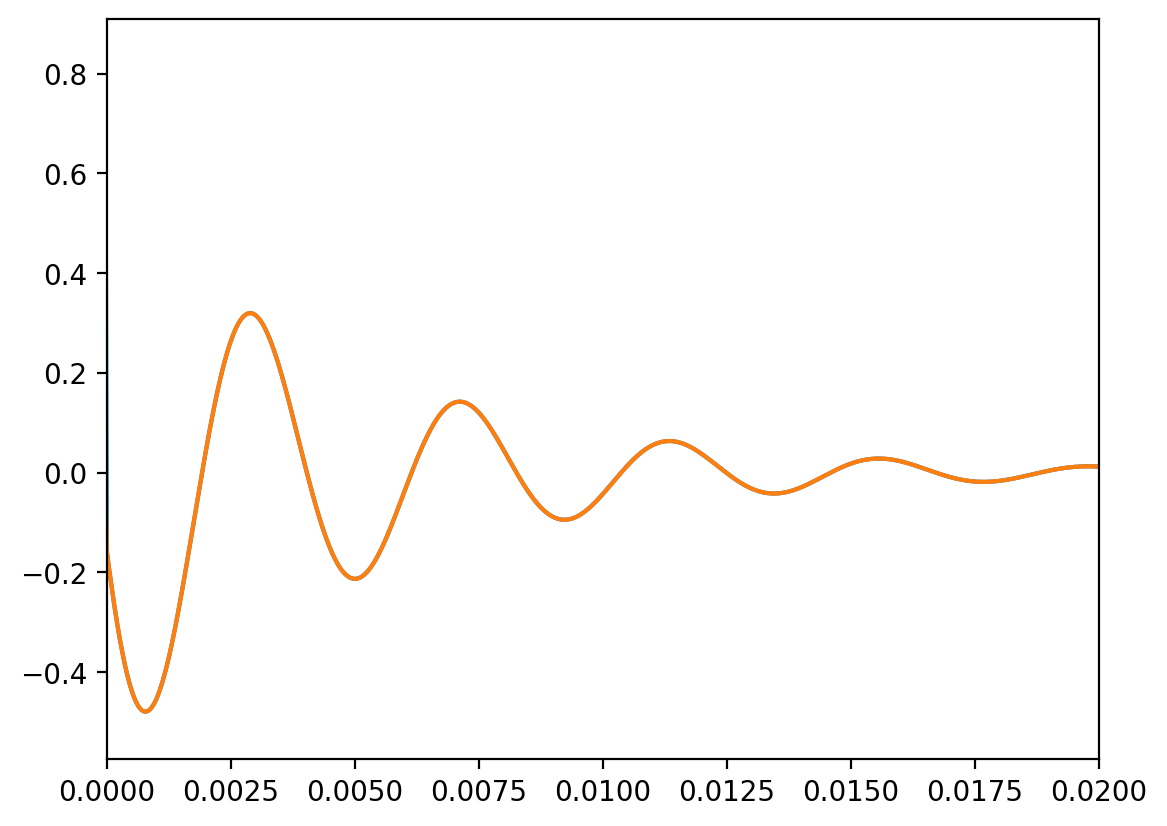

In [13]:
pl.plot(fit.filtered_data['H1'])
pl.plot(t_range, analytic_filtered)
pl.xlim(0, 0.02)

(0.0, 300.0)

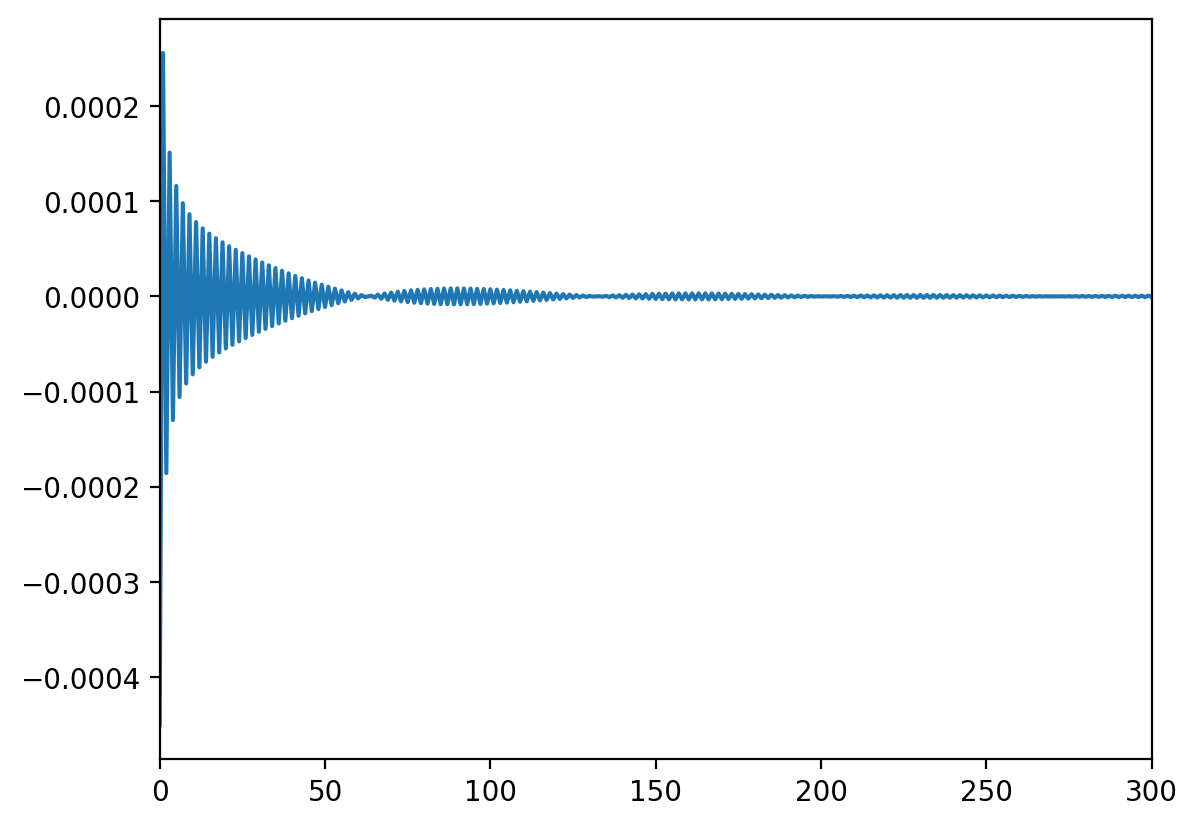

In [14]:
pos_idx = fit.filtered_data['H1'].index>=0
pl.plot(fit.filtered_data['H1'].values[pos_idx]**2 - analytic_filtered[len(analytic_filtered)//2:]**2)
pl.xlim(0, 300)